In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
metrics = pd.read_csv('public_metrics.csv', index_col=0)
conditions = pd.read_csv('public_conditions.csv', index_col=0)
stats = pd.read_csv('public_stats.csv', index_col=0)

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
concentration = pd.read_table('ERCC_Controls_Analysis.txt', index_col=1)['concentration in Mix 1 (attomoles/ul)']

In [6]:
idx = conditions.query('protocol == "inDrop"').sample().iloc[0].name
s = stats.loc[idx, concentration.index]
s

ERCC ID
ERCC-00130    41.0
ERCC-00004    25.0
ERCC-00136     9.0
ERCC-00108     7.0
ERCC-00116     1.0
ERCC-00092     4.0
ERCC-00095     3.0
ERCC-00131     2.0
ERCC-00062     0.0
ERCC-00019     1.0
ERCC-00144     1.0
ERCC-00170     1.0
ERCC-00154     0.0
ERCC-00085     0.0
ERCC-00028     0.0
ERCC-00033     0.0
ERCC-00134     0.0
ERCC-00147     0.0
ERCC-00097     0.0
ERCC-00156     0.0
ERCC-00123     0.0
ERCC-00017     0.0
ERCC-00083     0.0
ERCC-00096    42.0
ERCC-00171    11.0
ERCC-00009     3.0
ERCC-00042     8.0
ERCC-00060     6.0
ERCC-00035     0.0
ERCC-00025     1.0
              ... 
ERCC-00040     0.0
ERCC-00164     0.0
ERCC-00024     0.0
ERCC-00016     0.0
ERCC-00012     0.0
ERCC-00098     0.0
ERCC-00057     0.0
ERCC-00002    55.0
ERCC-00046    13.0
ERCC-00003     6.0
ERCC-00043    11.0
ERCC-00022     0.0
ERCC-00112     2.0
ERCC-00165     2.0
ERCC-00079     1.0
ERCC-00078     3.0
ERCC-00163     0.0
ERCC-00059     0.0
ERCC-00160     1.0
ERCC-00014     0.0
ERCC-00077     0.0
ERCC

In [7]:
conditions.loc[s.name]

dilution      5000
volume           1
protocol    inDrop
Name: SRP053052_SRR1784317_CTATAGAGGAGTGATTGCTTGTGACGCCTT, dtype: object

In [8]:
input_molecules = \
conditions['volume'][s.name] * 1e-3 * \
1. / (conditions['dilution'][s.name]) * 1e-18 * \
6.02214179 * 1e23 * \
concentration

In [9]:
df = pd.DataFrame({'input': input_molecules, 'expression': s})

In [10]:
mod = smf.ols(formula='np.log10(expression / input) ~ 1', data=df.replace(0, np.nan).dropna())

In [11]:
res = mod.fit()

In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.log10(expression / input)   R-squared:                       0.000
Model:                                      OLS   Adj. R-squared:                  0.000
Method:                           Least Squares   F-statistic:                       nan
Date:                          Thu, 18 Aug 2016   Prob (F-statistic):                nan
Time:                                  10:37:06   Log-Likelihood:                -23.895
No. Observations:                            34   AIC:                             49.79
Df Residuals:                                33   BIC:                             51.32
Df Model:                                     0                                         
Covariance Type:                      nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.0387      0.085    -12.211      0.000        -1.212    -0.866
==============================================================================
Omnibus:                        0.443   Durbin-Watson:                   0.895
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.591
Skew:                           0.170   Prob(JB):                        0.744
Kurtosis:                       2.451   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
e = 10 ** (res.params['Intercept'])
e

0.09147271416312229

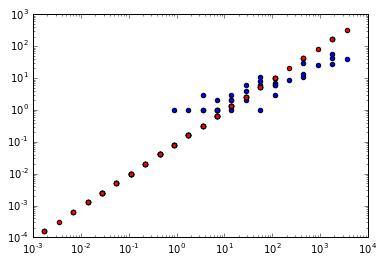

In [14]:
plt.loglog()
plt.scatter(df.input, df.expression);
plt.scatter(df.input, df.input * e, c='r');

In [15]:
from tqdm import tqdm

In [16]:
conditions.protocol.value_counts()

MARS-Seq         14965
STRT-Seq          3197
CEL-Seq           2170
Smart-Seq2        1165
SMARTer (C1)      1136
GemCode           1015
inDrop             629
Tang               363
Bulk               199
BATSeq             144
GnT-Seq            104
CEL-Seq2 (C1)       96
DropSeq             84
SUPeR-Seq           54
CEL-Seq2            44
Name: protocol, dtype: int64

In [17]:
efficiency = pd.Series(index=conditions.query('protocol in ["MARS-Seq", "STRT-Seq", "CEL-Seq", "GemCode", "inDrop", "BATSeq", "CEL-Seq2 (C1)", "DropSeq", "CEL-Seq2"]').index)
for idx in tqdm(efficiency.index):
    s = stats.loc[idx, concentration.index]
    
    # Need at least 8 observations to fit model
    if (s > 0.1).sum() < 8:
        efficiency[idx] = np.nan
        continue
        
    input_molecules = \
    conditions['volume'][s.name] * 1e-3 * \
    1. / (conditions['dilution'][s.name]) * 1e-18 * \
    6.02214179 * 1e23 * \
    concentration
    
    df = pd.DataFrame({'input': input_molecules, 'expression': s}).dropna()
    df = df.query('expression > 0.1')
    
    mod = smf.ols(formula='np.log10(expression / input) ~ 1', data=df)
    res = mod.fit()
    e = 10 ** (res.params['Intercept'])
    
    efficiency[idx] = e

In [18]:
efficiency.name = 'efficiency'
umi = conditions[['protocol']].join(efficiency, how='inner')

In [19]:
import seaborn as sns

In [20]:
sns.set_style('ticks')

In [21]:
color_map = pd.read_table('figures_rev_1/colourCoding.txt', index_col=0, squeeze=True)

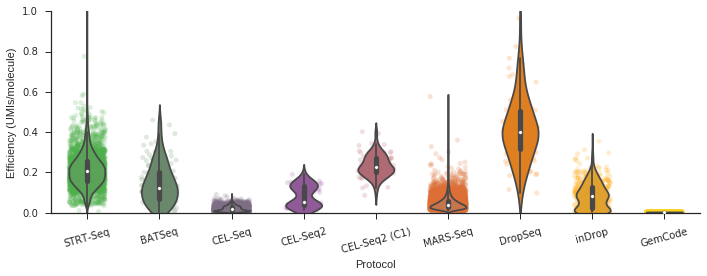

In [22]:
order = ["STRT-Seq", "BATSeq", "CEL-Seq", "CEL-Seq2", "CEL-Seq2 (C1)", "MARS-Seq", "DropSeq", "inDrop", "GemCode"]

figsize(10, 4)
sns.stripplot(x='protocol', y='efficiency', data=umi, jitter=0.25, zorder=1, palette=color_map.to_dict(), order=order, alpha=0.2, rasterized=True)
sns.violinplot(x='protocol', y='efficiency', data=umi, scale='width', zorder=2, inner='box', width=0.5, palette=color_map.to_dict(), order=order, )
plt.xticks(rotation=15);
sns.despine()

plt.ylim(0., 1.);
plt.tight_layout();
sns.axlabel('Protocol', 'Efficiency (UMIs/molecule)')
plt.savefig('figures_rev_1/umi-efficiency.pdf')

In [30]:
metrics['molecule_limit'] = \
conditions['volume'] * 1e-3 * \
1. / (conditions['dilution']) * 1e-18 * \
6.02214179 * 1e23 * \
metrics['concentration_limit']

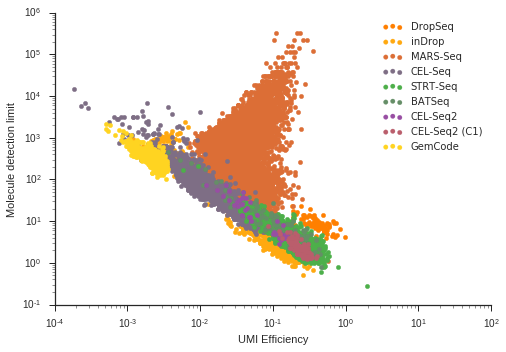

In [53]:
tmp = umi.join(metrics)
g = sns.FacetGrid(tmp, hue='protocol', palette=color_map.to_dict(), size=5, aspect=1.5)
g.map(plt.scatter, 'efficiency', 'molecule_limit', rasterized=True);
g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.ax.set_xlim(1e-4, 1e2)
plt.legend(scatterpoints=3);
sns.axlabel('UMI Efficiency', 'Molecule detection limit');
plt.savefig('figures_rev_1/umi-efficiency-vs-detection-limit.pdf', dpi=300)

In [48]:
pwd

'/nfs/research2/teichmann/valentine/detection-comparison'

In [168]:
sns.violinplot?

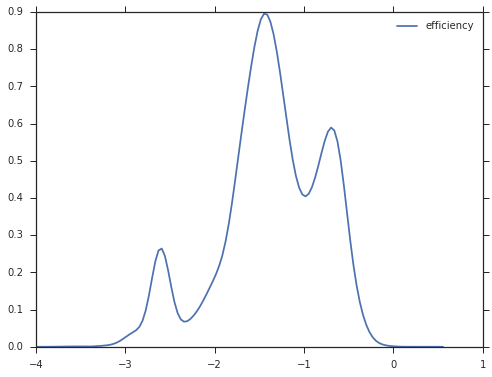

In [129]:
sns.kdeplot(np.log10(efficiency).dropna());

In [101]:
umi = umi.join(stats.reads)

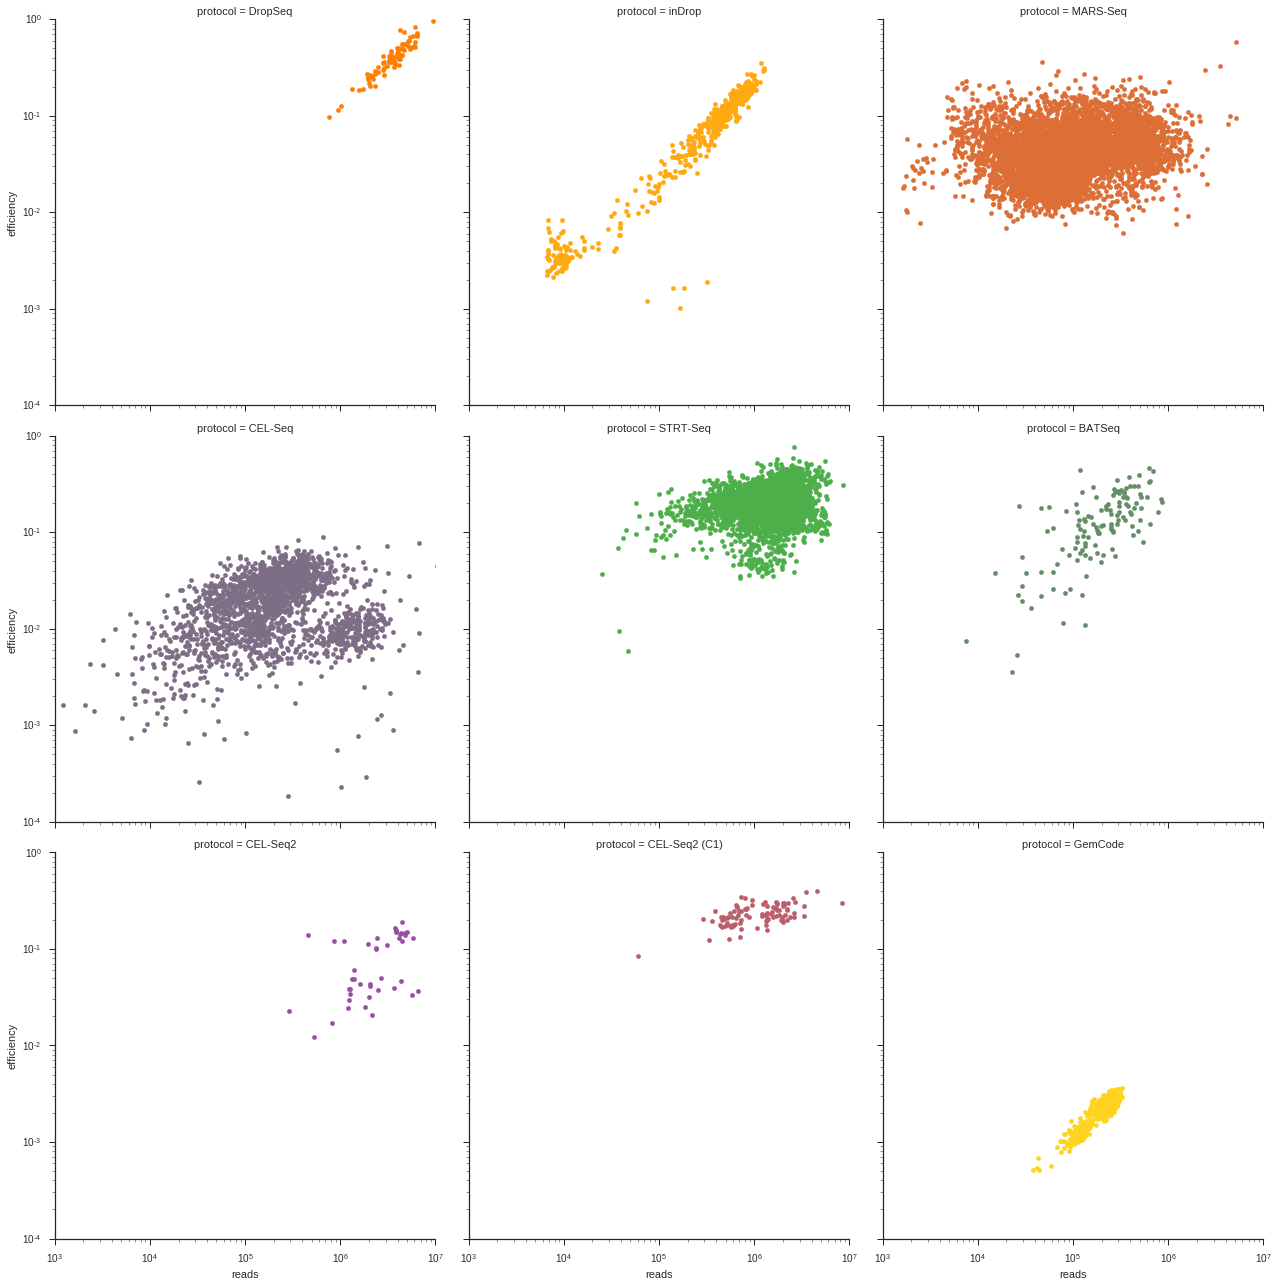

In [104]:
g = sns.FacetGrid(data=umi, col='protocol', hue='protocol', size=6, palette=color_map.to_dict(), col_wrap=3)
g.map(plt.scatter, 'reads', 'efficiency');
list(map(lambda a: a.set_xscale('log'), g.axes));
list(map(lambda a: a.set_yscale('log'), g.axes));
list(map(lambda a: a.set_xlim(1e3, 1e7), g.axes));
list(map(lambda a: a.set_ylim(1e-4, 1.), g.axes));
# plt.legend();

In [62]:
g.axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ab3fc65feb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2ab3fc184278>]], dtype=object)

In [105]:
umi['above_threshold'] = (umi.efficiency > 0.6)
umi.groupby('protocol').sum()['above_threshold'][order]

protocol
STRT-Seq         2.0
BATSeq           0.0
CEL-Seq          0.0
CEL-Seq2         0.0
CEL-Seq2 (C1)    0.0
MARS-Seq         0.0
DropSeq          9.0
inDrop           0.0
GemCode          0.0
Name: above_threshold, dtype: float64

In [113]:
params = pd.DataFrame(index=conditions.query('protocol in ["MARS-Seq", "STRT-Seq", "CEL-Seq", "GemCode", "inDrop", "BATSeq", "CEL-Seq2 (C1)", "DropSeq", "CEL-Seq2"]').index)
params['Intercept'] = np.nan
params['np.log10(input)'] = np.nan

for idx in tqdm(params.index):
    s = stats.loc[idx, concentration.index]
    
    # Need at least 8 observations to fit model
    if (s > 0.1).sum() < 8:
        efficiency[idx] = np.nan
        continue
        
    input_molecules = \
    conditions['volume'][s.name] * 1e-3 * \
    1. / (conditions['dilution'][s.name]) * 1e-18 * \
    6.02214179 * 1e23 * \
    concentration
    
    df = pd.DataFrame({'input': input_molecules, 'expression': s}).dropna()
    df = df.query('expression > 0.1')
    
    mod = smf.ols(formula='np.log10(expression) ~ np.log10(input) + 1', data=df)
    res = mod.fit()
    params.loc[idx] = res.params


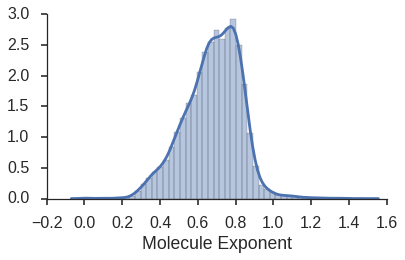

In [204]:
figsize(6, 4)
sns.distplot(params['np.log10(input)'].dropna());
sns.despine()
plt.xlabel('Molecule Exponent');
plt.tight_layout()
plt.savefig('figures_rev_1/supp-mol-exp-dist.pdf')

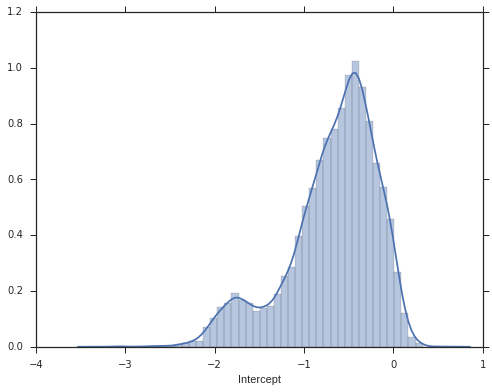

In [130]:
sns.distplot(params['Intercept'].dropna());

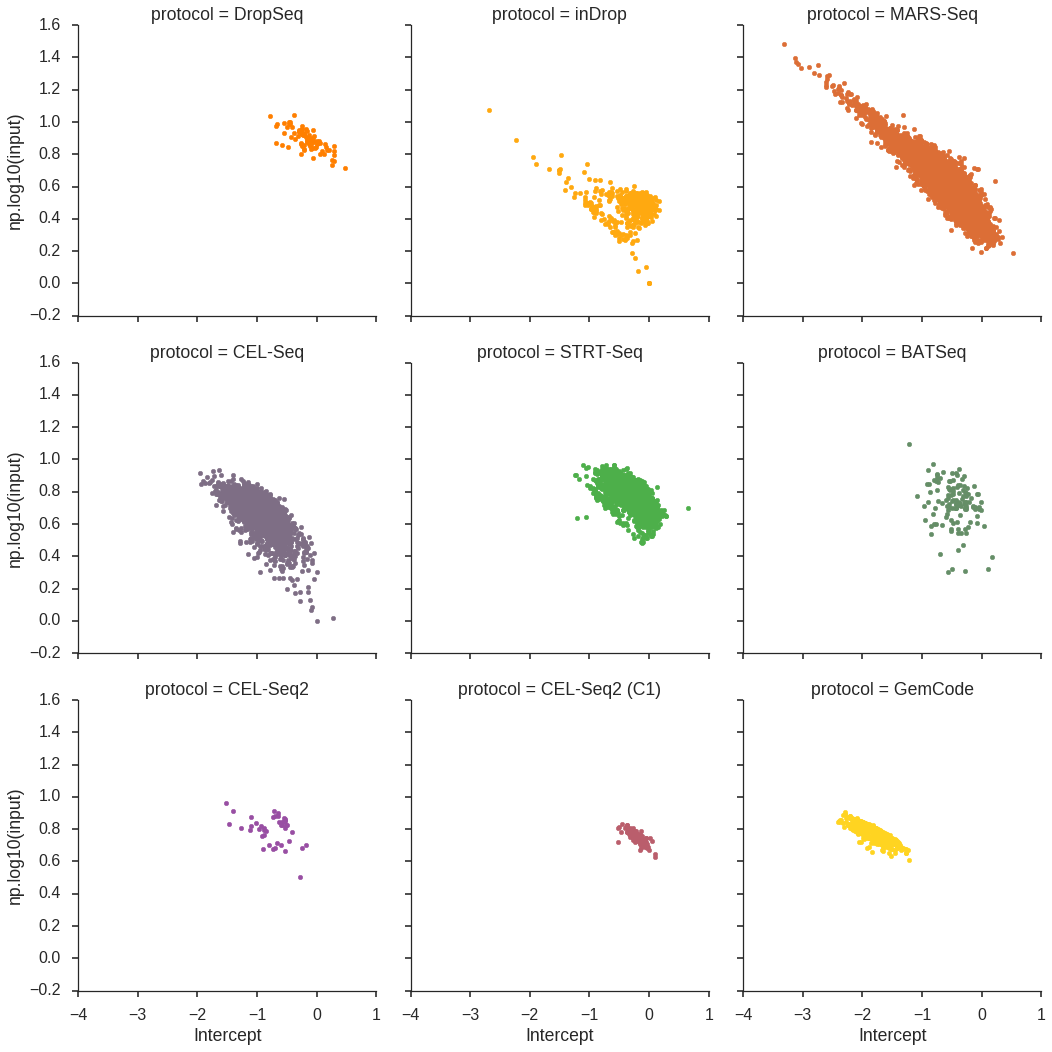

In [218]:
figsize(8, 6)
g = sns.FacetGrid(umi, hue='protocol', col='protocol', size=5, col_wrap=3, palette=color_map.to_dict())
g.map(plt.scatter, 'Intercept', 'np.log10(input)');

In [131]:
umi.protocol.value_counts()

MARS-Seq         14965
STRT-Seq          3197
CEL-Seq           2170
GemCode           1015
inDrop             629
BATSeq             144
CEL-Seq2 (C1)       96
DropSeq             84
CEL-Seq2            44
Name: protocol, dtype: int64

In [132]:
umi_length_map = {
    'CEL-Seq': 4,
    'MARS-Seq': 4,
    'GemCode': 10,
    'STRT-Seq': 6,
    'inDrop': 6,
    'BATSeq': 8,
    'CEL-Seq2 (C1)': 6,
    'DropSeq': 8,
    'CEL-Seq2': 6
}

In [151]:
umi['umi_length'] = umi.protocol.map(umi_length_map.get)

In [137]:
umi = umi.join(params)

In [152]:
umi.head()

,protocol,efficiency,reads,above_threshold,Intercept,np.log10(input),umi_length
SRP056001_SRR1873278_AAACCTACCCGC,DropSeq,0.241033,1946039.0,False,-0.218836,0.835795,8
SRP056001_SRR1873278_AACATAGCGATT,DropSeq,0.511350,5722405.0,False,-0.067852,0.894764,8
SRP056001_SRR1873278_AAGTATGGTCCA,DropSeq,0.334660,4120243.0,False,-0.448084,0.988513,8
SRP056001_SRR1873278_AATGCGTGCGAT,DropSeq,0.386598,4204075.0,False,-0.149255,0.884432,8
SRP056001_SRR1873278_ACAATGATTACA,DropSeq,0.964443,9478622.0,True,0.287828,0.849192,8


In [189]:
sns.set_color_codes()

In [195]:
sns.set_context('poster')

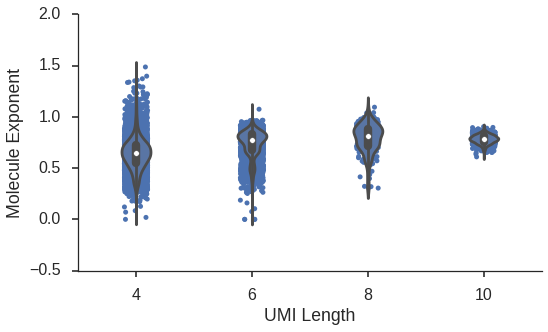

In [197]:
figsize(8, 5)
sns.stripplot('umi_length', 'np.log10(input)', data=umi, jitter=True, zorder=1, color='b', rasterized=True)
sns.violinplot('umi_length', 'np.log10(input)', data=umi, zorder=2, scale='width', width=.25, color='b')
sns.axlabel('UMI Length', 'Molecule Exponent');
sns.despine()
plt.tight_layout()
plt.savefig('figures_rev_1/supp-umi-length.pdf')

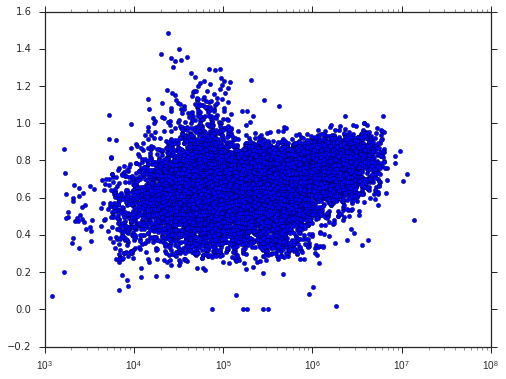

In [185]:
figsize(8, 6)
plt.xscale('log')
plt.scatter(umi['reads'], umi['np.log10(input)']);